<a href="https://colab.research.google.com/github/yegeniy/d2l-book/blob/master/chapter_preliminaries/probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

# Probability and Statistics
:label:`sec_prob`

One way or another,
machine learning is all about uncertainty.
In supervised learning, we want to predict
something unknown (the *target*)
given something known (the *features*).
Depending on our objective,
we might attempt to predict
the most likely value of the target.
Or we might predict the value with the smallest
expected distance from the target.
And sometimes we wish not only
to predict a specific value
but to *quantify our uncertainty*.
For example, given some features
describing a patient,
we might want to know *how likely* they are
to suffer a heart attack in the next year.
In unsupervised learning,
we often care about uncertainty.
To determine whether a set of measurements are anomalous,
it helps to know how likely one is
to observe values in a population of interest.
Furthermore, in reinforcement learning,
we wish to develop agents
that act intelligently in various environments.
This requires reasoning about
how an environment might be expected to change
and what rewards one might expect to encounter
in response to each of the available actions.

*Probability* is the mathematical field
concerned with reasoning under uncertainty.
Given a probabilistic model of some process,
we can reason about the likelihood of various events.
The use of probabilities to describe
the frequencies of repeatable events
(like coin tosses)
is fairly uncontroversial.
In fact, *frequentist* scholars adhere
to an interpretation of probability
that applies *only* to such repeatable events.
By contrast *Bayesian* scholars
use the language of probability more broadly
to formalize reasoning under uncertainty.
Bayesian probability is characterized
by two unique features:
(i) assigning degrees of belief
to non-repeatable events,
e.g., what is the *probability*
that a dam will collapse?;
and (ii) subjectivity. While Bayesian
probability provides unambiguous rules
for how one should update their beliefs
in light of new evidence,
it allows for different individuals
to start off with different *prior* beliefs.
*Statistics* helps us to reason backwards,
starting off with collection and organization of data
and backing out to what inferences
we might draw about the process
that generated the data.
Whenever we analyze a dataset, hunting for patterns
that we hope might characterize a broader population,
we are employing statistical thinking.
Many courses, majors, theses, careers, departments,
companies, and institutions have been devoted
to the study of probability and statistics.
While this section only scratches the surface,
we will provide the foundation
that you need to begin building models.


In [ ]:
%matplotlib inline
import random
import torch
import matplotlib.pyplot as plt
from torch.distributions.multinomial import Multinomial
# from d2l import torch as d2l

## A Simple Example: Tossing Coins

Imagine that we plan to toss a coin
and want to quantify how likely
we are to see heads (vs. tails).
If the coin is *fair*,
then both outcomes
(heads and tails),
are equally likely.
Moreover if we plan to toss the coin $n$ times
then the fraction of heads
that we *expect* to see
should exactly match
the *expected* fraction of tails.
One intuitive way to see this
is by symmetry:
for every possible outcome
with $n_\textrm{h}$ heads and $n_\textrm{t} = (n - n_\textrm{h})$ tails,
there is an equally likely outcome
with $n_\textrm{t}$ heads and $n_\textrm{h}$ tails.
Note that this is only possible
if on average we expect to see
$1/2$ of tosses come up heads
and $1/2$ come up tails.
Of course, if you conduct this experiment
many times with $n=1000000$ tosses each,
you might never see a trial
where $n_\textrm{h} = n_\textrm{t}$ exactly.


Formally, the quantity $1/2$ is called a *probability*
and here it captures the certainty with which
any given toss will come up heads.
Probabilities assign scores between $0$ and $1$
to outcomes of interest, called *events*.
Here the event of interest is $\textrm{heads}$
and we denote the corresponding probability $P(\textrm{heads})$.
A probability of $1$ indicates absolute certainty
(imagine a trick coin where both sides were heads)
and a probability of $0$ indicates impossibility
(e.g., if both sides were tails).
The frequencies $n_\textrm{h}/n$ and $n_\textrm{t}/n$ are not probabilities
but rather *statistics*.
Probabilities are *theoretical* quantities
that underly the data generating process.
Here, the probability $1/2$
is a property of the coin itself.
By contrast, statistics are *empirical* quantities
that are computed as functions of the observed data.
Our interests in probabilistic and statistical quantities
are inextricably intertwined.
We often design special statistics called *estimators*
that, given a dataset, produce *estimates*
of model parameters such as probabilities.
Moreover, when those estimators satisfy
a nice property called *consistency*,
our estimates will converge
to the corresponding probability.
In turn, these inferred probabilities
tell about the likely statistical properties
of data from the same population
that we might encounter in the future.

Suppose that we stumbled upon a real coin
for which we did not know
the true $P(\textrm{heads})$.
To investigate this quantity
with statistical methods,
we need to (i) collect some data;
and (ii) design an estimator.
Data acquisition here is easy;
we can toss the coin many times
and record all the outcomes.
Formally, drawing realizations
from some underlying random process
is called *sampling*.
As you might have guessed,
one natural estimator
is the ratio of
the number of observed *heads*
to the total number of tosses.

Now, suppose that the coin was in fact fair,
i.e., $P(\textrm{heads}) = 0.5$.
To simulate tosses of a fair coin,
we can invoke any random number generator.
There are some easy ways to draw samples
of an event with probability $0.5$.
For example Python's `random.random`
yields numbers in the interval $[0,1]$
where the probability of lying
in any sub-interval $[a, b] \subset [0,1]$
is equal to $b-a$.
Thus we can get out `0` and `1` with probability `0.5` each
by testing whether the returned float number is greater than `0.5`:


In [ ]:
num_tosses = 100
heads = sum([random.random() > 0.5 for _ in range(num_tosses)])
tails = num_tosses - heads
print("heads, tails: ", [heads, tails])

heads, tails:  [44, 56]


More generally, we can simulate multiple draws
from any variable with a finite number
of possible outcomes
(like the toss of a coin or roll of a die)
by calling the multinomial function,
setting the first argument
to the number of draws
and the second as a list of probabilities
associated with each of the possible outcomes.
To simulate ten tosses of a fair coin,
we assign probability vector `[0.5, 0.5]`,
interpreting index 0 as heads
and index 1 as tails.
The function returns a vector
with length equal to the number
of possible outcomes (here, 2),
where the first component tells us
the number of occurrences of heads
and the second component tells us
the number of occurrences of tails.


In [ ]:
fair_probs = torch.tensor([0.5, 0.5])
Multinomial(100, fair_probs).sample()

tensor([47., 53.])

In [ ]:
import torch as th
th.tensor([ 21.,  24.,  30.,  25.]).sum()

tensor(100.)

Each time you run this sampling process,
you will receive a new random value
that may differ from the previous outcome.
Dividing by the number of tosses
gives us the *frequency*
of each outcome in our data.
Note that these frequencies,
just like the probabilities
that they are intended
to estimate, sum to $1$.


In [ ]:
Multinomial(100, fair_probs).sample() / 100

tensor([0.5400, 0.4600])

In [ ]:
Multinomial(100, fair_probs).sample((4_000_000,)).shape

torch.Size([4000000, 2])

In [ ]:
import torch
import time
from torch.distributions.multinomial import Multinomial

st = time.time()

total_min=50
ct = 0
bs = 4_000_000
while time.time() - st < 60:
  ct += 1
  batch_min = torch.min(
    Multinomial(100, torch.tensor([0.5, 0.5], device='cuda'))
      .sample((bs,)))
  if batch_min < total_min:
    total_min = batch_min
    print(f"{batch_min.item()=}, {ct=}, @{int(time.time() - st)}s")

print()
print(f"{total_min=}, {ct=}, {bs*ct*1.0:=4.2e}")

batch_min.item()=23.0, ct=1, @0s
batch_min.item()=21.0, ct=9, @1s
batch_min.item()=20.0, ct=126, @14s
batch_min.item()=18.0, ct=322, @37s

total_min=tensor(18., device='cuda:0'), ct=519, 2.08e+09


*here is some intuition for what a normal distribution looks like computationally.*

*When flipping one hundred fair coins, you should expect to see 80:20 results as soon as within tens of millions of trials. But don't expect many trials more extreme than 18. I've never seen 17 across many billion of trials.*

*You might encounter:*

```
batch_min=tensor(26., device='cuda:0'), ct=1
batch_min=tensor(24., device='cuda:0'), ct=2
batch_min=tensor(23., device='cuda:0'), ct=3
batch_min=tensor(22., device='cuda:0'), ct=5
batch_min=tensor(21., device='cuda:0'), ct=481
batch_min=tensor(19., device='cuda:0'), ct=983

total_min=tensor(19., device='cuda:0'), ct=1023, bs*ct=2046000000
```

```
batch_min=tensor(23., device='cuda:0'), ct=1, @0s
batch_min=tensor(20., device='cuda:0'), ct=9, @1s

total_min=tensor(20., device='cuda:0'), ct=81, 3.24e+08
```


```
batch_min=tensor(26., device='cuda:0'), ct=1, @0s
batch_min=tensor(23., device='cuda:0'), ct=2, @0s
batch_min=tensor(22., device='cuda:0'), ct=7, @0s
batch_min=tensor(20., device='cuda:0'), ct=19, @2s
batch_min=tensor(18., device='cuda:0'), ct=88, @10s

total_min=tensor(18., device='cuda:0'), ct=522, 2.09e+09
```

```
batch_min.item()=23.0, ct=1, @0s
batch_min.item()=21.0, ct=9, @1s
batch_min.item()=20.0, ct=126, @14s
batch_min.item()=18.0, ct=322, @37s

total_min=tensor(18., device='cuda:0'), ct=519, 2.08e+09
```

Here, even though our simulated coin is fair
(we ourselves set the probabilities `[0.5, 0.5]`),
the counts of heads and tails may not be identical.
That is because we only drew a relatively small number of samples.
If we did not implement the simulation ourselves,
and only saw the outcome,
how would we know if the coin were slightly unfair
or if the possible deviation from $1/2$ was
just an artifact of the small sample size?
Let's see what happens when we simulate 10,000 tosses.


In [ ]:
counts = Multinomial(10000, fair_probs).sample()
counts / 10000

tensor([0.4966, 0.5034])

In general, for averages of repeated events (like coin tosses),
as the number of repetitions grows,
our estimates are guaranteed to converge
to the true underlying probabilities.
The mathematical formulation of this phenomenon
is called the *law of large numbers*
and the *central limit theorem*
tells us that in many situations,
as the sample size $n$ grows,
these errors should go down
at a rate of $(1/\sqrt{n})$.
Let's get some more intuition by studying
how our estimate evolves as we grow
the number of tosses from 1 to 10,000.


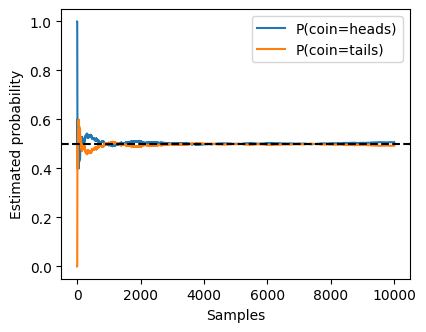

In [ ]:
counts = Multinomial(1, fair_probs).sample((10000,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)
estimates = estimates.numpy()

plt.figure(figsize=(4.5, 3.5))
plt.plot(estimates[:, 0], label=("P(coin=heads)"))
plt.plot(estimates[:, 1], label=("P(coin=tails)"))
plt.axhline(y=0.5, color='black', linestyle='dashed')
plt.gca().set_xlabel('Samples')
plt.gca().set_ylabel('Estimated probability')
plt.legend();

Each solid curve corresponds to one of the two values of the coin
and gives our estimated probability that the coin turns up that value
after each group of experiments.
The dashed black line gives the true underlying probability.
As we get more data by conducting more experiments,
the curves converge towards the true probability.
You might already begin to see the shape
of some of the more advanced questions
that preoccupy statisticians:
How quickly does this convergence happen?
If we had already tested many coins
manufactured at the same plant,
how might we incorporate this information?

##  A More Formal Treatment

We have already gotten pretty far: posing
a probabilistic model,
generating synthetic data,
running a statistical estimator,
empirically assessing convergence,
and reporting error metrics (checking the deviation).
However, to go much further,
we will need to be more precise.


When dealing with randomness,
we denote the set of possible outcomes $\mathcal{S}$
and call it the *sample space* or *outcome space*.
Here, each element is a distinct possible *outcome*.
In the case of rolling a single coin,
$\mathcal{S} = \{\textrm{heads}, \textrm{tails}\}$.
For a single die, $\mathcal{S} = \{1, 2, 3, 4, 5, 6\}$.
When flipping two coins, possible outcomes are
$\{(\textrm{heads}, \textrm{heads}), (\textrm{heads}, \textrm{tails}), (\textrm{tails}, \textrm{heads}),  (\textrm{tails}, \textrm{tails})\}$.
*Events* are subsets of the sample space.
For instance, the event "the first coin toss comes up heads"
corresponds to the set $\{(\textrm{heads}, \textrm{heads}), (\textrm{heads}, \textrm{tails})\}$.
Whenever the outcome $z$ of a random experiment satisfies
$z \in \mathcal{A}$, then event $\mathcal{A}$ has occurred.
For a single roll of a die, we could define the events
"seeing a $5$" ($\mathcal{A} = \{5\}$)
and "seeing an odd number"  ($\mathcal{B} = \{1, 3, 5\}$).
In this case, if the die came up $5$,
we would say that both $\mathcal{A}$ and $\mathcal{B}$ occurred.
On the other hand, if $z = 3$,
then $\mathcal{A}$ did not occur
but $\mathcal{B}$ did.


A *probability* function maps events
onto real values ${P: \mathcal{A} \subseteq \mathcal{S} \rightarrow [0,1]}$.
The probability, denoted $P(\mathcal{A})$, of an event $\mathcal{A}$
in the given sample space $\mathcal{S}$,
has the following properties:

* The probability of any event $\mathcal{A}$ is a nonnegative real number, i.e., $P(\mathcal{A}) \geq 0$;
* The probability of the entire sample space is $1$, i.e., $P(\mathcal{S}) = 1$;
* For any countable sequence of events $\mathcal{A}_1, \mathcal{A}_2, \ldots$ that are *mutually exclusive* (i.e., $\mathcal{A}_i \cap \mathcal{A}_j = \emptyset$ for all $i \neq j$), the probability that any of them happens is equal to the sum of their individual probabilities, i.e., $P(\bigcup_{i=1}^{\infty} \mathcal{A}_i) = \sum_{i=1}^{\infty} P(\mathcal{A}_i)$.

These axioms of probability theory,
proposed by :citet:`Kolmogorov.1933`,
can be applied to rapidly derive a number of important consequences.
For instance, it follows immediately
that the probability of any event $\mathcal{A}$
*or* its complement $\mathcal{A}'$ occurring is 1
(because $\mathcal{A} \cup \mathcal{A}' = \mathcal{S}$).
We can also prove that $P(\emptyset) = 0$
because $1 = P(\mathcal{S} \cup \mathcal{S}') = P(\mathcal{S} \cup \emptyset) = P(\mathcal{S}) + P(\emptyset) = 1 + P(\emptyset)$.
Consequently, the probability of any event $\mathcal{A}$
*and* its complement $\mathcal{A}'$ occurring simultaneously
is $P(\mathcal{A} \cap \mathcal{A}') = 0$.
Informally, this tells us that impossible events
have zero probability of occurring.



## Random Variables

When we spoke about events like the roll of a die
coming up odds or the first coin toss coming up heads,
we were invoking the idea of a *random variable*.
Formally, random variables are mappings
from an underlying sample space
to a set of (possibly many) values.
You might wonder how a random variable
is different from the sample space,
since both are collections of outcomes.
Importantly, random variables can be much coarser
than the raw sample space.
We can define a binary random variable like "greater than 0.5"
even when the underlying sample space is infinite,
e.g., points on the line segment between $0$ and $1$.
Additionally, multiple random variables
can share the same underlying sample space.
For example "whether my home alarm goes off"
and "whether my house was burgled"
are both binary random variables
that share an underlying sample space.
Consequently, knowing the value taken by one random variable
can tell us something about the likely value of another random variable.
Knowing that the alarm went off,
we might suspect that the house was likely burgled.


Every value taken by a random variable corresponds
to a subset of the underlying sample space.
Thus the occurrence where the random variable $X$
takes value $v$, denoted by $X=v$, is an *event*
and $P(X=v)$ denotes its probability.
Sometimes this notation can get clunky,
and we can abuse notation when the context is clear.
For example, we might use $P(X)$ to refer broadly
to the *distribution* of $X$, i.e.,
the function that tells us the probability
that $X$ takes any given value.
Other times we write expressions
like $P(X,Y) = P(X) P(Y)$,
as a shorthand to express a statement
that is true for all of the values
that the random variables $X$ and $Y$ can take, i.e.,
for all $i,j$ it holds that $P(X=i \textrm{ and } Y=j) = P(X=i)P(Y=j)$.
Other times, we abuse notation by writing
$P(v)$ when the random variable is clear from the context.
Since an event in probability theory is a set of outcomes from the sample space,
we can specify a range of values for a random variable to take.
For example, $P(1 \leq X \leq 3)$ denotes the probability of the event $\{1 \leq X \leq 3\}$.


Note that there is a subtle difference
between *discrete* random variables,
like flips of a coin or tosses of a die,
and *continuous* ones,
like the weight and the height of a person
sampled at random from the population.
In this case we seldom really care about
someone's exact height.
Moreover, if we took precise enough measurements,
we would find that no two people on the planet
have the exact same height.
In fact, with fine enough measurements,
you would never have the same height
when you wake up and when you go to sleep.
There is little point in asking about
the exact probability that someone
is 1.801392782910287192 meters tall.
Instead, we typically care more about being able to say
whether someone's height falls into a given interval,
say between 1.79 and 1.81 meters.
In these cases we work with probability *densities*.
The height of exactly 1.80 meters
has no probability, but nonzero density.
To work out the probability assigned to an interval,
we must take an *integral* of the density
over that interval.

## Multiple Random Variables

You might have noticed that we could not even
make it through the previous section without
making statements involving interactions
among multiple random variables
(recall $P(X,Y) = P(X) P(Y)$).
Most of machine learning
is concerned with such relationships.
Here, the sample space would be
the population of interest,
say customers who transact with a business,
photographs on the Internet,
or proteins known to biologists.
Each random variable would represent
the (unknown) value of a different attribute.
Whenever we sample an individual from the population,
we observe a realization of each of the random variables.
Because the values taken by random variables
correspond to subsets of the sample space
that could be overlapping, partially overlapping,
or entirely disjoint,
knowing the value taken by one random variable
can cause us to update our beliefs
about which values of another random variable are likely.
If a patient walks into a hospital
and we observe that they
are having trouble breathing
and have lost their sense of smell,
then we believe that they are more likely
to have COVID-19 than we might
if they had no trouble breathing
and a perfectly ordinary sense of smell.


When working with multiple random variables,
we can construct events corresponding
to every combination of values
that the variables can jointly take.
The probability function that assigns
probabilities to each of these combinations
(e.g. $A=a$ and $B=b$)
is called the *joint probability* function
and simply returns the probability assigned
to the intersection of the corresponding subsets
of the sample space.
The *joint probability* assigned to the event
where random variables $A$ and $B$
take values $a$ and $b$, respectively,
is denoted $P(A = a, B = b)$,
where the comma indicates "and".
Note that for any values $a$ and $b$,
it follows that

$$P(A=a, B=b) \leq P(A=a) \textrm{ and } P(A=a, B=b) \leq P(B = b),$$

since for $A=a$ and $B=b$ to happen,
$A=a$ has to happen *and* $B=b$ also has to happen.
Interestingly, the joint probability
tells us all that we can know about these
random variables in a probabilistic sense,
and can be used to derive many other
useful quantities, including recovering the
individual distributions $P(A)$ and $P(B)$.
To recover $P(A=a)$ we simply sum up
$P(A=a, B=v)$ over all values $v$
that the random variable $B$ can take:
$P(A=a) = \sum_v P(A=a, B=v)$.


The ratio $\frac{P(A=a, B=b)}{P(A=a)} \leq 1$
turns out to be extremely important.
It is called the *conditional probability*,
and is denoted via the "$\mid$" symbol:

$$P(B=b \mid A=a) = P(A=a,B=b)/P(A=a).$$

It tells us the new probability
associated with the event $B=b$,
once we condition on the fact $A=a$ took place.
We can think of this conditional probability
as restricting attention only to the subset
of the sample space associated with $A=a$
and then renormalizing so that
all probabilities sum to 1.
Conditional probabilities
are in fact just ordinary probabilities
and thus respect all of the axioms,
as long as we condition all terms
on the same event and thus
restrict attention to the same sample space.
For instance, for disjoint events
$\mathcal{B}$ and $\mathcal{B}'$, we have that
$P(\mathcal{B} \cup \mathcal{B}' \mid A = a) = P(\mathcal{B} \mid A = a) + P(\mathcal{B}' \mid A = a)$.


Using the definition of conditional probabilities,
we can derive the famous result called *Bayes' theorem*.
By construction, we have that $P(A, B) = P(B\mid A) P(A)$
and $P(A, B) = P(A\mid B) P(B)$.
Combining both equations yields
$P(B\mid A) P(A) = P(A\mid B) P(B)$ and hence

$$P(A \mid B) = \frac{P(B\mid A) P(A)}{P(B)}.$$






This simple equation has profound implications because
it allows us to reverse the order of conditioning.
If we know how to estimate $P(B\mid A)$, $P(A)$, and $P(B)$,
then we can estimate $P(A\mid B)$.
We often find it easier to estimate one term directly
but not the other and Bayes' theorem can come to the rescue here.
For instance, if we know the prevalence of symptoms for a given disease,
and the overall prevalences of the disease and symptoms, respectively,
we can determine how likely someone is
to have the disease based on their symptoms.
In some cases we might not have direct access to $P(B)$,
such as the prevalence of symptoms.
In this case a simplified version of Bayes' theorem comes in handy:

$$P(A \mid B) \propto P(B \mid A) P(A).$$

Since we know that $P(A \mid B)$ must be normalized to $1$, i.e., $\sum_a P(A=a \mid B) = 1$,
we can use it to compute

$$P(A \mid B) = \frac{P(B \mid A) P(A)}{\sum_a P(B \mid A=a) P(A = a)}.$$

In Bayesian statistics, we think of an observer
as possessing some (subjective) prior beliefs
about the plausibility of the available hypotheses
encoded in the *prior* $P(H)$,
and a *likelihood function* that says how likely
one is to observe any value of the collected evidence
for each of the hypotheses in the class $P(E \mid H)$.
Bayes' theorem is then interpreted as telling us
how to update the initial *prior* $P(H)$
in light of the available evidence $E$
to produce *posterior* beliefs
$P(H \mid E) = \frac{P(E \mid H) P(H)}{P(E)}$.
Informally, this can be stated as
"posterior equals prior times likelihood, divided by the evidence".
Now, because the evidence $P(E)$ is the same for all hypotheses,
we can get away with simply normalizing over the hypotheses.

Note that $\sum_a P(A=a \mid B) = 1$ also allows us to *marginalize* over random variables. That is, we can drop variables from a joint distribution such as $P(A, B)$. After all, we have that

$$\sum_a P(B \mid A=a) P(A=a) = \sum_a P(B, A=a) = P(B).$$

Independence is another fundamentally important concept
that forms the backbone of
many important ideas in statistics.
In short, two variables are *independent*
if conditioning on the value of $A$ does not
cause any change to the probability distribution
associated with $B$ and vice versa.
More formally, independence, denoted $A \perp B$,
requires that $P(A \mid B) = P(A)$ and, consequently,
that $P(A,B) = P(A \mid B) P(B) = P(A) P(B)$.
Independence is often an appropriate assumption.
For example, if the random variable $A$
represents the outcome from tossing one fair coin
and the random variable $B$
represents the outcome from tossing another,
then knowing whether $A$ came up heads
should not influence the probability
of $B$ coming up heads.


Independence is especially useful when it holds among the successive
draws of our data from some underlying distribution
(allowing us to make strong statistical conclusions)
or when it holds among various variables in our data,
allowing us to work with simpler models
that encode this independence structure.
On the other hand, estimating the dependencies
among random variables is often the very aim of learning.
We care to estimate the probability of disease given symptoms
specifically because we believe
that diseases and symptoms are *not* independent.


Note that because conditional probabilities are proper probabilities,
the concepts of independence and dependence also apply to them.
Two random variables $A$ and $B$ are *conditionally independent*
given a third variable $C$ if and only if $P(A, B \mid C) = P(A \mid C)P(B \mid C)$.
Interestingly, two variables can be independent in general
but become dependent when conditioning on a third.
This often occurs when the two random variables $A$ and $B$
correspond to causes of some third variable $C$.
For example, broken bones and lung cancer might be independent
in the general population but if we condition on being in the hospital
then we might find that broken bones are negatively correlated with lung cancer.
That is because the broken bone *explains away* why some person is in the hospital
and thus lowers the probability that they are hospitalized because of having lung cancer.


And conversely, two dependent random variables
can become independent upon conditioning on a third.
This often happens when two otherwise unrelated events
have a common cause.
Shoe size and reading level are highly correlated
among elementary school students,
but this correlation disappears if we condition on age.



## An Example
:label:`subsec_probability_hiv_app`

Let's put our skills to the test.
Assume that a doctor administers an HIV test to a patient.
This test is fairly accurate and fails only with 1% probability
if the patient is healthy but reported as diseased,
i.e., healthy patients test positive in 1% of cases.
Moreover, it never fails to detect HIV if the patient actually has it.
We use $D_1 \in \{0, 1\}$ to indicate the diagnosis
($0$ if negative and $1$ if positive)
and $H \in \{0, 1\}$ to denote the HIV status.

| Conditional probability | $H=1$ | $H=0$ |
|:------------------------|------:|------:|
| $P(D_1 = 1 \mid H)$        |     1 |  0.01 |
| $P(D_1 = 0 \mid H)$        |     0 |  0.99 |

Note that the column sums are all 1 (but the row sums do not),
since they are conditional probabilities.
Let's compute the probability of the patient having HIV
if the test comes back positive, i.e., $P(H = 1 \mid D_1 = 1)$.
Intuitively this is going to depend on how common the disease is,
since it affects the number of false alarms.
Assume that the population is fairly free of the disease, e.g., $P(H=1) = 0.0015$.
To apply Bayes' theorem, we need to apply marginalization
to determine

$$\begin{aligned}
P(D_1 = 1)
=& P(D_1=1, H=0) + P(D_1=1, H=1)  \\
=& P(D_1=1 \mid H=0) P(H=0) + P(D_1=1 \mid H=1) P(H=1) \\
=& 0.011485.
\end{aligned}
$$

This leads us to

$$P(H = 1 \mid D_1 = 1) = \frac{P(D_1=1 \mid H=1) P(H=1)}{P(D_1=1)} = 0.1306.$$

In other words, there is only a 13.06% chance
that the patient actually has HIV,
despite the test being pretty accurate.
As we can see, probability can be counterintuitive.
What should a patient do upon receiving such terrifying news?
Likely, the patient would ask the physician
to administer another test to get clarity.
The second test has different characteristics
and it is not as good as the first one.

| Conditional probability | $H=1$ | $H=0$ |
|:------------------------|------:|------:|
| $P(D_2 = 1 \mid H)$          |  0.98 |  0.03 |
| $P(D_2 = 0 \mid H)$          |  0.02 |  0.97 |

Unfortunately, the second test comes back positive, too.
Let's calculate the requisite probabilities to invoke Bayes' theorem
by assuming conditional independence:

$$\begin{aligned}
P(D_1 = 1, D_2 = 1 \mid H = 0)
& = P(D_1 = 1 \mid H = 0) P(D_2 = 1 \mid H = 0)
=& 0.0003, \\
P(D_1 = 1, D_2 = 1 \mid H = 1)
& = P(D_1 = 1 \mid H = 1) P(D_2 = 1 \mid H = 1)
=& 0.98.
\end{aligned}
$$

Now we can apply marginalization to obtain the probability
that both tests come back positive:

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1)\\
&= P(D_1 = 1, D_2 = 1, H = 0) + P(D_1 = 1, D_2 = 1, H = 1)  \\
&= P(D_1 = 1, D_2 = 1 \mid H = 0)P(H=0) + P(D_1 = 1, D_2 = 1 \mid H = 1)P(H=1)\\
&= 0.00176955.
\end{aligned}
$$

Finally, the probability of the patient having HIV given that both tests are positive is

$$P(H = 1 \mid D_1 = 1, D_2 = 1)
= \frac{P(D_1 = 1, D_2 = 1 \mid H=1) P(H=1)}{P(D_1 = 1, D_2 = 1)}
= 0.8307.$$

That is, the second test allowed us to gain much higher confidence that not all is well.
Despite the second test being considerably less accurate than the first one,
it still significantly improved our estimate.
The assumption of both tests being conditionally independent of each other
was crucial for our ability to generate a more accurate estimate.
Take the extreme case where we run the same test twice.
In this situation we would expect the same outcome both times,
hence no additional insight is gained from running the same test again.
The astute reader might have noticed that the diagnosis behaved
like a classifier hiding in plain sight
where our ability to decide whether a patient is healthy
increases as we obtain more features (test outcomes).


## Expectations

Often, making decisions requires not just looking
at the probabilities assigned to individual events
but composing them together into useful aggregates
that can provide us with guidance.
For example, when random variables take continuous scalar values,
we often care about knowing what value to expect *on average*.
This quantity is formally called an *expectation*.
If we are making investments,
the first quantity of interest
might be the return we can expect,
averaging over all the possible outcomes
(and weighting by the appropriate probabilities).
For instance, say that with 50% probability,
an investment might fail altogether,
with 40% probability it might provide a 2$\times$ return,
and with 10% probability it might provide a 10$\times$ return 10$\times$.
To calculate the expected return,
we sum over all returns, multiplying each
by the probability that they will occur.
This yields the expectation
$0.5 \cdot 0 + 0.4 \cdot 2 + 0.1 \cdot 10 = 1.8$.
Hence the expected return is 1.8$\times$.


In general, the *expectation* (or average)
of the random variable $X$ is defined as

$$E[X] = E_{x \sim P}[x] = \sum_{x} x P(X = x).$$

Likewise, for densities we obtain $E[X] = \int x \;dp(x)$.
Sometimes we are interested in the expected value
of some function of $x$.
We can calculate these expectations as

$$E_{x \sim P}[f(x)] = \sum_x f(x) P(x) \textrm{ and } E_{x \sim P}[f(x)] = \int f(x) p(x) \;dx$$

for discrete probabilities and densities, respectively.
Returning to the investment example from above,
$f$ might be the *utility* (happiness)
associated with the return.
Behavior economists have long noted
that people associate greater disutility
with losing money than the utility gained
from earning one dollar relative to their baseline.
Moreover, the value of money tends to be sub-linear.
Possessing 100k dollars versus zero dollars
can make the difference between paying the rent,
eating well, and enjoying quality healthcare
versus suffering through homelessness.
On the other hand, the gains due to possessing
200k versus 100k are less dramatic.
Reasoning like this motivates the cliché
that "the utility of money is logarithmic".


If  the utility associated with a total loss were $-1$,
and the utilities associated with returns of $1$, $2$, and $10$
were $1$, $2$ and $4$, respectively,
then the expected happiness of investing
would be $0.5 \cdot (-1) + 0.4 \cdot 2 + 0.1 \cdot 4 = 0.7$
(an expected loss of utility of 30%).
If indeed this were your utility function,
you might be best off keeping the money in the bank.

For financial decisions,
we might also want to measure
how *risky* an investment is.
Here, we care not just about the expected value
but how much the actual values tend to *vary*
relative to this value.
Note that we cannot just take
the expectation of the difference
between the actual and expected values.
This is because the expectation of a difference
is the difference of the expectations,
i.e., $E[X - E[X]] = E[X] - E[E[X]] = 0$.
However, we can look at the expectation
of any non-negative function of this difference.
The *variance* of a random variable is calculated by looking
at the expected value of the *squared* differences:

$$\textrm{Var}[X] = E\left[(X - E[X])^2\right] = E[X^2] - E[X]^2.$$

Here the equality follows by expanding
$(X - E[X])^2 = X^2 - 2 X E[X] + E[X]^2$
and taking expectations for each term.
The square root of the variance is another
useful quantity called the *standard deviation*.
While this and the variance
convey the same information (either can be calculated from the other),
the standard deviation has the nice property
that it is expressed in the same units
as the original quantity represented
by the random variable.

Lastly, the variance of a function
of a random variable
is defined analogously as

$$\textrm{Var}_{x \sim P}[f(x)] = E_{x \sim P}[f^2(x)] - E_{x \sim P}[f(x)]^2.$$

Returning to our investment example,
we can now compute the variance of the investment.
It is given by $0.5 \cdot 0 + 0.4 \cdot 2^2 + 0.1 \cdot 10^2 - 1.8^2 = 8.36$.
For all intents and purposes this is a risky investment.
Note that by mathematical convention mean and variance
are often referenced as $\mu$ and $\sigma^2$.
This is particularly the case whenever we use it
to parametrize a Gaussian distribution.

In the same way as we introduced expectations
and variance for *scalar* random variables,
we can do so for vector-valued ones.
Expectations are easy, since we can apply them elementwise.
For instance, $\boldsymbol{\mu} \stackrel{\textrm{def}}{=} E_{\mathbf{x} \sim P}[\mathbf{x}]$
has coordinates $\mu_i = E_{\mathbf{x} \sim P}[x_i]$.
*Covariances* are more complicated.
We define them by taking expectations of the *outer product*
of the difference between random variables and their mean:

$$\boldsymbol{\Sigma} \stackrel{\textrm{def}}{=} \textrm{Cov}_{\mathbf{x} \sim P}[\mathbf{x}] = E_{\mathbf{x} \sim P}\left[(\mathbf{x} - \boldsymbol{\mu}) (\mathbf{x} - \boldsymbol{\mu})^\top\right].$$

This matrix $\boldsymbol{\Sigma}$ is referred to as the covariance matrix.
An easy way to see its effect is to consider some vector $\mathbf{v}$
of the same size as $\mathbf{x}$.
It follows that

$$\mathbf{v}^\top \boldsymbol{\Sigma} \mathbf{v} = E_{\mathbf{x} \sim P}\left[\mathbf{v}^\top(\mathbf{x} - \boldsymbol{\mu}) (\mathbf{x} - \boldsymbol{\mu})^\top \mathbf{v}\right] = \textrm{Var}_{x \sim P}[\mathbf{v}^\top \mathbf{x}].$$

As such, $\boldsymbol{\Sigma}$ allows us to compute the variance
for any linear function of $\mathbf{x}$
by a simple matrix multiplication.
The off-diagonal elements tell us how correlated the coordinates are:
a value of 0 means no correlation,
where a larger positive value
means that they are more strongly correlated.



## Discussion

In machine learning, there are many things to be uncertain about!
We can be uncertain about the value of a label given an input.
We can be uncertain about the estimated value of a parameter.
We can even be uncertain about whether data arriving at deployment
is even from the same distribution as the training data.

By *aleatoric uncertainty*, we mean uncertainty
that is intrinsic to the problem,
and due to genuine randomness
unaccounted for by the observed variables.
By *epistemic uncertainty*, we mean uncertainty
over a model's parameters, the sort of uncertainty
that we can hope to reduce by collecting more data.
We might have epistemic uncertainty
concerning the probability
that a coin turns up heads,
but even once we know this probability,
we are left with aleatoric uncertainty
about the outcome of any future toss.
No matter how long we watch someone tossing a fair coin,
we will never be more or less than 50% certain
that the next toss will come up heads.
These terms come from mechanical modeling,
(see e.g., :citet:`Der-Kiureghian.Ditlevsen.2009` for a review on this aspect of [uncertainty quantification](https://en.wikipedia.org/wiki/Uncertainty_quantification)).
It is worth noting, however, that these terms constitute a slight abuse of language.
The term *epistemic* refers to anything concerning *knowledge*
and thus, in the philosophical sense, all uncertainty is epistemic.


We saw that sampling data from some unknown probability distribution
can provide us with information that can be used to estimate
the parameters of the data generating distribution.
That said, the rate at which this is possible can be quite slow.
In our coin tossing example (and many others)
we can do no better than to design estimators
that converge at a rate of $1/\sqrt{n}$,
where $n$ is the sample size (e.g., the number of tosses).
This means that by going from 10 to 1000 observations (usually a very achievable task)
we see a tenfold reduction of uncertainty,
whereas the next 1000 observations help comparatively little,
offering only a 1.41 times reduction.
This is a persistent feature of machine learning:
while there are often easy gains, it takes a very large amount of data,
and often with it an enormous amount of computation, to make further gains.
For an empirical review of this fact for large scale language models see :citet:`Revels.Lubin.Papamarkou.2016`.

We also sharpened our language and tools for statistical modeling.
In the process of that we learned about conditional probabilities
and about one of the most important equations in statistics---Bayes' theorem.
It is an effective tool for decoupling information conveyed by data
through a likelihood term $P(B \mid A)$ that addresses
how well observations $B$ match a choice of parameters $A$,
and a prior probability $P(A)$ which governs how plausible
a particular choice of $A$ was in the first place.
In particular, we saw how this rule can be applied
to assign probabilities to diagnoses,
based on the efficacy of the test *and*
the prevalence of the disease itself (i.e., our prior).

Lastly, we introduced a first set of nontrivial questions
about the effect of a specific probability distribution,
namely expectations and variances.
While there are many more than just linear and quadratic
expectations for a probability distribution,
these two already provide a good deal of knowledge
about the possible behavior of the distribution.
For instance, [Chebyshev's inequality](https://en.wikipedia.org/wiki/Chebyshev%27s_inequality)
states that $P(|X - \mu| \geq k \sigma) \leq 1/k^2$,
where $\mu$ is the expectation, $\sigma^2$ is the variance of the distribution,
and $k > 1$ is a confidence parameter of our choosing.
It tells us that draws from a distribution lie
with at least 50% probability
within a $[-\sqrt{2} \sigma, \sqrt{2} \sigma]$
interval centered on the expectation.




## Exercises

1. Give an example where observing more data can reduce the amount of uncertainty about the outcome to an arbitrarily low level.
1. Give an example where observing more data will only reduce the amount of uncertainty up to a point and then no further. Explain why this is the case and where you expect this point to occur.
1. We empirically demonstrated convergence to the mean for the toss of a coin. Calculate the variance of the estimate of the probability that we see a head after drawing $n$ samples.
    1. How does the variance scale with the number of observations?
    1. Use Chebyshev's inequality to bound the deviation from the expectation.
    1. How does it relate to the central limit theorem?
1. Assume that we draw $m$ samples $x_i$ from a probability distribution with zero mean and unit variance. Compute the averages $z_m \stackrel{\textrm{def}}{=} m^{-1} \sum_{i=1}^m x_i$. Can we apply Chebyshev's inequality for every $z_m$ independently? Why not?
1. Given two events with probability $P(\mathcal{A})$ and $P(\mathcal{B})$, compute upper and lower bounds on $P(\mathcal{A} \cup \mathcal{B})$ and $P(\mathcal{A} \cap \mathcal{B})$. Hint: graph the situation using a [Venn diagram](https://en.wikipedia.org/wiki/Venn_diagram).
1. Assume that we have a sequence of random variables, say $A$, $B$, and $C$, where $B$ only depends on $A$, and $C$ only depends on $B$, can you simplify the joint probability $P(A, B, C)$? Hint: this is a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain).
1. In :numref:`subsec_probability_hiv_app`, assume that the outcomes of the two tests are not independent. In particular assume that either test on its own has a false positive rate of 10% and a false negative rate of 1%. That is, assume that $P(D =1 \mid H=0) = 0.1$ and that $P(D = 0 \mid H=1) = 0.01$. Moreover, assume that for $H = 1$ (infected) the test outcomes are conditionally independent, i.e., that $P(D_1, D_2 \mid H=1) = P(D_1 \mid H=1) P(D_2 \mid H=1)$ but that for healthy patients the outcomes are coupled via $P(D_1 = D_2 = 1 \mid H=0) = 0.02$.
    1. Work out the joint probability table for $D_1$ and $D_2$, given $H=0$ based on the information you have so far.
    1. Derive the probability that the patient is diseased ($H=1$) after one test returns positive. You can assume the same baseline probability $P(H=1) = 0.0015$ as before.
    1. Derive the probability that the patient is diseased ($H=1$) after both tests return positive.
1. Assume that you are an asset manager for an investment bank and you have a choice of stocks $s_i$ to invest in. Your portfolio needs to add up to $1$ with weights $\alpha_i$ for each stock. The stocks have an average return $\boldsymbol{\mu} = E_{\mathbf{s} \sim P}[\mathbf{s}]$ and covariance $\boldsymbol{\Sigma} = \textrm{Cov}_{\mathbf{s} \sim P}[\mathbf{s}]$.
    1. Compute the expected return for a given portfolio $\boldsymbol{\alpha}$.
    1. If you wanted to maximize the return of the portfolio, how should you choose your investment?
    1. Compute the *variance* of the portfolio.
    1. Formulate an optimization problem of maximizing the return while keeping the variance constrained to an upper bound. This is the Nobel-Prize winning [Markovitz portfolio](https://en.wikipedia.org/wiki/Markowitz_model) :cite:`Mangram.2013`. To solve it you will need a quadratic programming solver, something way beyond the scope of this book.


[Discussions](https://discuss.d2l.ai/t/37)


In [ ]:
%matplotlib inline
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions.multinomial import Multinomial
# from d2l import torch as d2l

### 1. Give an example where observing more data can reduce the amount of uncertainty about the outcome to an arbitrarily low level.


flipping a coin carefully (without damaging it). It's ultimately going reveal its true probability.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multinomial import Multinomial


In [ ]:
r = torch.rand(1).item()
p = torch.tensor([r, 1-r]) # probabilities
# p = torch.tensor([0.5, 0.5])
n = 1_000_000
outcomes = Multinomial(1, p).sample((n,))

p

tensor([0.5686, 0.4314])

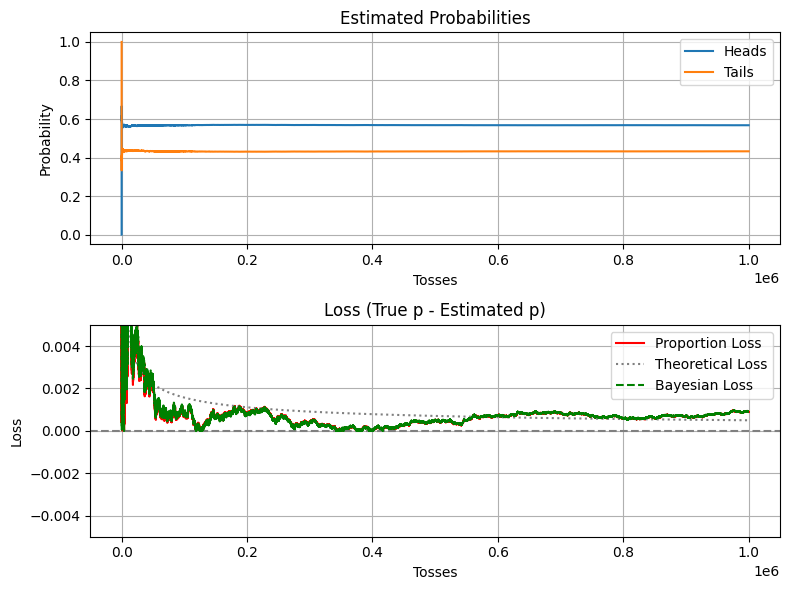

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

cumul = outcomes.cumsum(dim=0)
prop_est = cumul / (cumul.sum(dim=1, keepdims=True) + 1e-8)
pic = axs[0]
pic.plot(prop_est[:, 0], label='Heads')
pic.plot(prop_est[:, 1], label='Tails')
pic.set_xlabel('Tosses'); pic.set_ylabel('Probability'); pic.legend(); pic.grid(True)
pic.set_title('Estimated Probabilities')

loss = torch.abs(prop_est[:, 0] - r)
tosses = np.arange(1, n+1)
loss_guide = np.sqrt(r*(1-r))/np.sqrt(tosses)
pic = axs[1]
pic.plot(loss, label="Proportion Loss", color='red')
pic.plot(tosses, loss_guide, label="Theoretical Loss", color='gray', linestyle='dotted')
pic.axhline(y=0, color='gray', linestyle='dashed')

a_pri, b_pri = 1.0, 1.0
a_pst = a_pri + cumul[:, 0]
b_pst = b_pri + cumul[:, 1]
bayes_est = (a_pst) / (a_pst + b_pst)
bayesian_loss = torch.abs(r - bayes_est)
pic.plot(bayesian_loss, label="Bayesian Loss", color='green', linestyle='dashed')


pic.set_ylim(-.005, 0.005)
pic.set_xlabel('Tosses'); pic.set_ylabel('Loss'); pic.legend(); pic.grid(True)
pic.set_title('Loss (True p - Estimated p)')

plt.tight_layout()
plt.show()

### 2. Give an example where observing more data will only reduce the amount of uncertainty up to a point and then no further. Explain why this is the case and where you expect this point to occur.


observing lightning strikes within a storm. There is an inherent randomness to the phenomenon. At least insofar as we can model it. That randomness will reveal itself as the point of granularity of our estimate is shrunk.

In [ ]:
cx, cy, w = torch.randint(100, (3, ))
cx.item(), cy.item()
n = 10000
# lightning strikes around the center.
strikes = torch.stack([cx + torch.randint(-w, w, size=(n,)),
                       cy + torch.randint(-w, w, size=(n,))],
                      dim=1)
strikes.shape, strikes[0:2,:]

(torch.Size([10000, 2]),
 tensor([[59, 61],
         [58, 58]]))

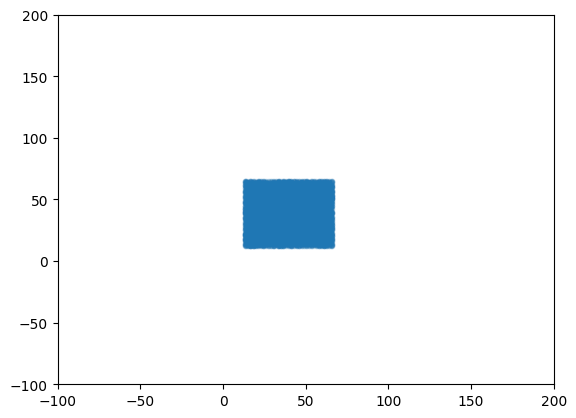

In [ ]:
plt.xlim(-100, 200)
plt.ylim(-100, 200)
plt.scatter(strikes[:, 0], strikes[:, 1], alpha=0.1, marker=".");

In [ ]:
assert n == strikes.shape[0]

In [ ]:

strikes.cumsum(dim=0).shape, torch.arange(1,n+1).shape
assert (strikes[:-1,:].cumsum(dim=0) / torch.arange(1,n).unsqueeze(1)).shape == (n-1, 2)


In [ ]:
prop_est = torch.cat((
    torch.tensor([[50, 50]]),
    strikes[:-1,:].cumsum(dim=0) / torch.arange(1,n).unsqueeze(1)
))
(cx, cy), prop_est.shape, prop_est[2000:2010,:]

((tensor(40), tensor(39)),
 torch.Size([10000, 2]),
 tensor([[39.0525, 38.8325],
         [39.0495, 38.8416],
         [39.0405, 38.8287],
         [39.0359, 38.8372],
         [39.0379, 38.8473],
         [39.0319, 38.8549],
         [39.0314, 38.8664],
         [39.0239, 38.8595],
         [39.0194, 38.8616],
         [39.0184, 38.8512]]))

In [ ]:

prop_est, strikes, (prop_est-strikes).pow(2)

(tensor([[50.0000, 50.0000],
         [59.0000, 61.0000],
         [58.5000, 59.5000],
         ...,
         [39.5221, 38.5796],
         [39.5239, 38.5777],
         [39.5266, 38.5759]]),
 tensor([[59, 61],
         [58, 58],
         [21, 30],
         ...,
         [58, 20],
         [66, 20],
         [19, 30]]),
 tensor([[8.1000e+01, 1.2100e+02],
         [1.0000e+00, 9.0000e+00],
         [1.4062e+03, 8.7025e+02],
         ...,
         [3.4143e+02, 3.4520e+02],
         [7.0098e+02, 3.4513e+02],
         [4.2134e+02, 7.3545e+01]]))

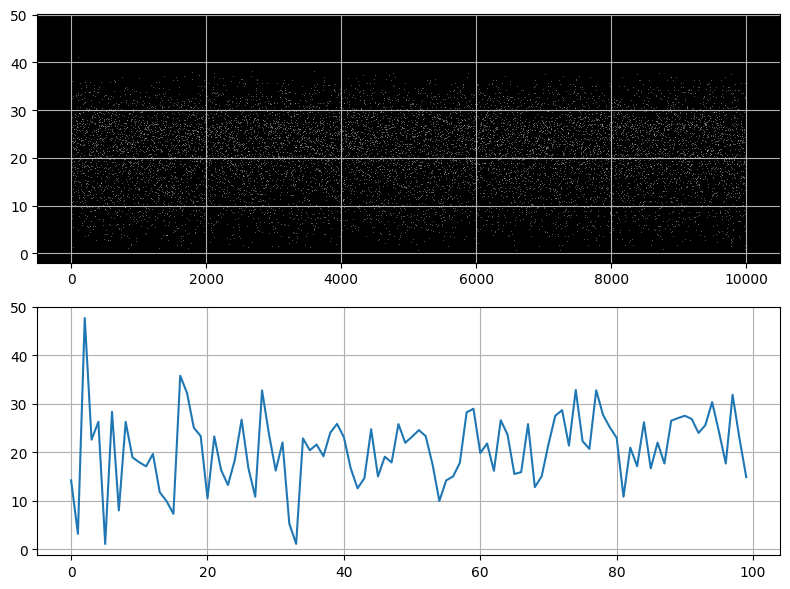

In [ ]:
# let's plot it
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

prop_loss = torch.sqrt((prop_est-strikes).pow(2).sum(dim=1))
pic = axs[0]
pic.set_facecolor("black")
pic.plot(prop_loss, marker=",", linestyle="", alpha=0.4, color="lightgray")
pic.grid(True)


pic = axs[1]
# pic.set_facecolor("black")
pic.plot(prop_loss[:100])
pic.grid(True)

plt.tight_layout()
plt.show()

note the fuzzy pattern around `w` (the width of the storm... ish)...

that's about what the loss is. It converges almost immediately.

### 3. We empirically demonstrated convergence to the mean for the toss of a coin. Calculate the variance of the estimate of the probability that we see a head after drawing $n$ samples.
 1. How does the variance scale with the number of observations?
 1. Use Chebyshev's inequality to bound the deviation from the expectation.
 1. How does it relate to the central limit theorem?


Let's apply Chebyshev's inequality to our coin toss example. We will calculate the upper bound on the probability that our estimated probability of heads deviates from the true probability (0.5) by a certain amount $\epsilon$.

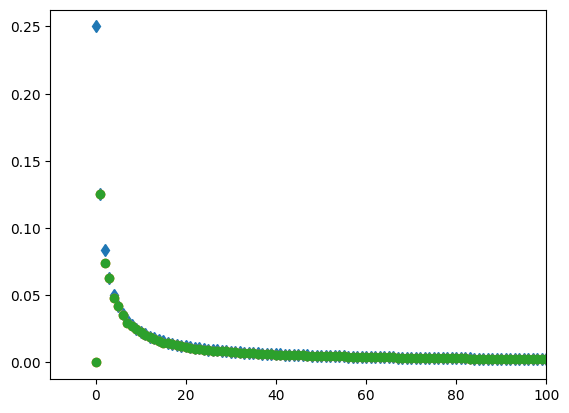

In [54]:
import torch
import matplotlib.pyplot as plt
from torch.distributions.multinomial import Multinomial

m = 10000
n = torch.arange(1, m+1)
p = 0.5
v = p*(1-p)/n
outcomes = Multinomial(1, torch.tensor([0.5, 0.5])).sample((m,))
cumul = outcomes.cumsum(dim=0)
prop_est = cumul / (cumul.sum(dim=1, keepdims=True) + 1e-8)
v_est = prop_est*(1-prop_est)/n.unsqueeze(1)
plt.plot(v, marker="d", linestyle="")
plt.plot(v_est, marker="o", linestyle="")
plt.xlim(-10,100)
# plt.ylim(0, 0.01)
plt.show()

In [16]:
v

tensor([2.5000e-01, 1.2500e-01, 8.3333e-02,  ..., 2.5000e-07, 2.5000e-07,
        2.5000e-07])

the variance scales with 1/n.

### 4. Assume that we draw $m$ samples $x_i$ from a probability distribution with zero mean and unit variance. Compute the averages $z_m \stackrel{\textrm{def}}{=} m^{-1} \sum_{i=1}^m x_i$. Can we apply Chebyshev's inequality for every $z_m$ independently? Why not?


### 5. Given two events with probability $P(\mathcal{A})$ and $P(\mathcal{B})$, compute upper and lower bounds on $P(\mathcal{A} \cup \mathcal{B})$ and $P(\mathcal{A} \cap \mathcal{B})$. Hint: graph the situation using a [Venn diagram](https://en.wikipedia.org/wiki/Venn_diagram).


### 6. Assume that we have a sequence of random variables, say $A$, $B$, and $C$, where $B$ only depends on $A$, and $C$ only depends on $B$, can you simplify the joint probability $P(A, B, C)$? Hint: this is a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain).


### 7. In :numref:`subsec_probability_hiv_app`, assume that the outcomes of the two tests are not independent. In particular assume that either test on its own has a false positive rate of 10% and a false negative rate of 1%. That is, assume that $P(D =1 \mid H=0) = 0.1$ and that $P(D = 0 \mid H=1) = 0.01$. Moreover, assume that for $H = 1$ (infected) the test outcomes are conditionally independent, i.e., that $P(D_1, D_2 \mid H=1) = P(D_1 \mid H=1) P(D_2 \mid H=1)$ but that for healthy patients the outcomes are coupled via $P(D_1 = D_2 = 1 \mid H=0) = 0.02$.
  1. Work out the joint probability table for $D_1$ and $D_2$, given $H=0$ based on the information you have so far.
  1. Derive the probability that the patient is diseased ($H=1$) after one test returns positive. You can assume the same baseline probability $P(H=1) = 0.0015$ as before.
  1. Derive the probability that the patient is diseased ($H=1$) after both tests return positive.


### 8. Assume that you are an asset manager for an investment bank and you have a choice of stocks $s_i$ to invest in. Your portfolio needs to add up to $1$ with weights $\alpha_i$ for each stock. The stocks have an average return $\boldsymbol{\mu} = E_{\mathbf{s} \sim P}[\mathbf{s}]$ and covariance $\boldsymbol{\Sigma} = \textrm{Cov}_{\mathbf{s} \sim P}[\mathbf{s}]$.
  1. Compute the expected return for a given portfolio $\boldsymbol{\alpha}$.
  1. If you wanted to maximize the return of the portfolio, how should you choose your investment?
  1. Compute the *variance* of the portfolio.
  1. Formulate an optimization problem of maximizing the return while keeping the variance constrained to an upper bound. This is the Nobel-Prize winning [Markovitz portfolio](https://en.wikipedia.org/wiki/Markowitz_model) :cite:`Mangram.2013`. To solve it you will need a quadratic programming solver, something way beyond the scope of this book.
